# Project: Dynamics of Bargaining Pwer
# Multi Objective Static Model (weighted sum)

#### Genaro, Itza, & Sonia
#### May 2021 

This code was made specifically to solve the static multi-objective model of principal-agent proposed in (cite) 

This aplication uses the JuMP library and the Ipopt solver to solve the optimization problrem given a value for the bargaining power.

The use uf this library allows us to easily change the parametrization of the problem and rely on a robust solver to find solutions in multi-criteria non-linear restricted optimization problems. 

## Libraries

In [9]:
using DataFrames
using XLSX 
using JuMP # Loading optimization libraries.
using Ipopt # Ipopt solves a nonlinear optimization problem.
using ExcelFiles  # Loading excel files libraries.

## Utility Functions

In [16]:
v(c,a,g=1,alpha=1)=-exp(g*(a-alpha*c))  # Declaration of v (agent utility function); 
                                        # g is the coefficient of risk aversion
                                        # alpha is a cost coefficientv

#v(c, a, h=0.50) =  (c^(1-h))/(1-h)- a^2 #CRA Function 
                                    #h is a oefficient of risk aversion
                                    # a is the agent effort

u(y,w)=y-w  #Declaration of the principal utility function 
            #y is the current output
            #w is the salary paid to the agent

u (generic function with 1 method)

## High Effort Model Specification 

In [17]:
function Model_High_Effort(h, delta)
    """
    This functions declares and solves the High effort model for the weighted sum of agent and principal utilities 
    Returns optimal values if found 
    """
    model_high_effort = Model(
            with_optimizer(
                Ipopt.Optimizer, 
                tol = 1e-7, 
                max_iter = 1000, 
                print_level=1)) 

    # Declare the decision variables for the model: xl = wl, xh = wh.
    @variable(model_high_effort, xl >= 0.00001)  # xl = wl, low compensation.
    @variable(model_high_effort, xh >= 0.00001)  # xh = wh, hight compensation.

    # Declare the agent's utility function within the model.
    register(model_high_effort, :v, 3, v, autodiff=true)    # m, the model name
                                            # :v,  **********                                          
                                            # 2, number of variables
                                            # v, declare the agent's utility function 
                                            # autodiff,    **********
    register(model_high_effort, :u, 2, u, autodiff=true) 

    # Non-linear type expressions are declared, the expected utility of the agent, within the model. 
    EV_H = @NLexpression(model_high_effort, f[1,1]*v(xh,A[2], h)+f[1,2]*v(xl,A[2],h))    # E(v|ah)
    EV_L = @NLexpression(model_high_effort, f[2,1]*v(xh,A[1],h)+f[2,2]*v(xl,A[1],h))    # E(v|al)
    EU_H = @NLexpression(model_high_effort, f[1,1]*u(Y[2],xh)+f[1,2]*u(Y[1],xl)) #E(U|ah)

    # Objective function; expected utility of the principal given ah.
    @NLobjective(model_high_effort, Max, delta*EV_H+(1-delta)*EU_H ) 

    @constraint(model_high_effort, xh<=Y[2])  # Financial capacity restriction for high compensation; wh<=yh.
    @constraint(model_high_effort, xl<=Y[1])  # Financial capacity restriction for low compensation; wl<=yl.

    @NLconstraint(model_high_effort, EV_H >= EV_L) # Incentive constraint to incentivize ah.
    
    # The problem posed for incentive ah is solved.
    JuMP.optimize!(model_high_effort) 
    wh = value(xh)
    wl = value(xl)
    uh = (f[1,1]*u(Y[2],wh)+f[1,2]*u(Y[1],wl))/(1-beta)
    vh = (f[1,1]*v(wh,A[2], h)+f[1,2]*v(wl,A[2],h))/(1-beta)
    
    return uh, vh, (wh, wl), termination_status(model_high_effort) 
end

Model_High_Effort (generic function with 1 method)

## Low Effort Model Specification

In [18]:
function Model_Low_Effort(h, delta)
    """
    This functions declares and solves the Low effort model for the weighted sum of agent and principal utilities 
    Returns optimal values if found 
    """
    model_low_effort = Model(
        with_optimizer(
            Ipopt.Optimizer, 
            tol = 1e-7, 
            max_iter = 1000,
            print_level=1))

    # Declare the decision variables for the model: xl = wl, xh = wh.
    @variable(model_low_effort, xl >= 0.00001)  # xl = wl, low compensation.
    @variable(model_low_effort, xh >= 0.00001)  # xh = wh, hight compensation.

    # Declare the agent's utility function within the model.
    register(model_low_effort, :v, 3, v, autodiff=true)    # m, the model name
                                            # :v,  **********                                          
                                            # 2, number of variables
                                            # v, declare the agent's utility function 
                                            # autodiff,    **********

    register(model_low_effort, :u, 2, u, autodiff=true) 

    # Non-linear type expressions are declared, the expected utility of the agent, within the model. 
    EV_H = @NLexpression(model_low_effort, f[1,1]*v(xh,A[2], h) + f[1,2]*v(xl,A[2],h)) #E(v|ah)
    EV_L = @NLexpression(model_low_effort, f[2,1]*v(xh,A[1], h) + f[2,2]*v(xl,A[1],h)) #E(v|al)
    EU_L = @NLexpression(model_low_effort,  f[2,1]*u(Y[2],xh)+f[2,2]*u(Y[1],xl)) #E(U|al)

    # Objective function; expected utility of the principal given al.
    @NLobjective(model_low_effort, Max, delta*EV_L+(1-delta)*EU_L) 

    @constraint(model_low_effort, xh <= Y[2]) # Financial capacity restriction for high compensation; wh<=yh.
    @constraint(model_low_effort, xl <= Y[1]) # Financial capacity restriction for low compensation; wl<=yl.

    @NLconstraint(model_low_effort, EV_H <= EV_L)  # Incentive constraint to incentivize al.

    # The problem posed for incentive al is solved.
    JuMP.optimize!(model_low_effort)

    # The optimal value of the function is saved given al.
    wh = value(xh)
    wl = value(xl)
    ul = (f[2,1]*u(Y[2],wh)+f[2,2]*u(Y[1],wl))/(1-beta)
    vl = (f[2,1]*v(wh,A[1], h) + f[2,2]*v(wl,A[1],h))/(1-beta)
    
    return ul, vl, (wh, wl), termination_status(model_low_effort)
end

Model_Low_Effort (generic function with 1 method)

### Feasible Bargaining Powers

In [19]:
function min_delta(h)
    """
    This function returns the minimun bargaining porwer of the agent that guarantees interior solutions
    """
    delta = 0 
    #Solve high effort for delta_0 = 0
    uh, vh, comp_high, stat_high = Model_High_Effort(h, delta)
    #Solve low eefort for delta_0 = 0
    ul, vl, comp_low, stat_low = Model_Low_Effort(h, delta)
    #Choose the model that optimizes the weighted utility sum. 
    if delta*vh+(1-delta)*uh>delta*vl+(1-delta)*ul
            v = vh
        else
            v = vl 
        end
    vf = copy(v) 
    #Search delta_t such that we find interior solution 
    while round.(v,digits = 5) == round.(vf,digits = 5)
        delta += 0.01 #Update delta_t
        #Solve high effort for delta_t
        uh, vh, comp_high, stat_high = Model_High_Effort(h, delta)
        #Solve low effort for delta_t
        ul, vl, comp_low, stat_low = Model_Low_Effort(h, delta)
        #Choose the model that optimizes the weighted utility sum.
        if delta*vh+(1-delta)*uh>delta*vl+(1-delta)*ul
            vf = vh
        else
            vf = vl 
        end
    end
    return delta - 0.01 #Return delta_min 
end


function max_delta(h)
    """
    This function returns the maximum bargaining porwer of the agent that guarantees interior solutions
    """
    delta = 1
    #Solve high effort for delta_0 = 1
    uh, vh, comp_high, stat_high = Model_High_Effort(h, delta)
    #Solve low effort for delta_0 = 1
    ul, vl, comp_low, stat_low = Model_Low_Effort(h, delta)
    #Choose the model that optimizes the weighted utility sum.
    if delta*vh+(1-delta)*uh>delta*vl+(1-delta)*ul
        v = vh
    else
        v = vl 
    end
    vf = copy(v)
    #Search delta_t such that we find interior solution 
    while round.(v,digits = 5) == round.(vf,digits = 5)
        delta -= 0.01
        #Solve high effort for delta_t
        uh, vh, comp_high, stat_high = Model_High_Effort(h, delta)
        #Solve low effort for delta_t
        ul, vl, comp_low, stat_low = Model_Low_Effort(h, delta)
        #Choose the model that optimizes the weighted utility sum.
        if delta*vh+(1-delta)*uh>delta*vl+(1-delta)*ul
            vf = vh
        else
            vf = vl 
        end
    end
    return delta+0.01 #return delta_max
end

max_delta (generic function with 1 method)

## Variables and Lists

In [21]:
A = [0.1 0.2]    # Actions set [al ah]
Y = [0.4 0.8]    # Outcomes set [yl yh]
f = [2/3 1/3; 1/3 2/3]    # Probability matrix  [yh|ah yl|ah; yh|al yl|al]
beta = 0.96 # Future discount factor
h = 1 #Parameter for agent utility 
dl = min_delta(h) #Min bargaining power
dh =  max_delta(h) #Max bargaining power
println(dl,dh)
n = trunc(Int, ceil((dh-dl)*200+1)) #Number of intervals for the bargaining power
Deltas = LinRange(dl,dh,n) #List of bargaining powers

0.32000000000000010.6499999999999997


67-element LinRange{Float64}:
 0.32,0.325,0.33,0.335,0.34,0.345,0.35,…,0.62,0.625,0.63,0.635,0.64,0.645,0.65

## Routine 

In [22]:
function Static_Pareto_Frontier(Deltas, n, h)
    """
    This functions finds the pareto frontier for the Multi Objective Static Model  
    Returns optimal values if found 
    """
    u_val = 0 #Initialization of the principal utility for the current bargaining power
    v_val = 0 #Initialization of the agent utility for the current bargaining power
    U= [] #List of principal Utilities
    V= [] #List of agent utilities
    Acc_opt= [] #List of reccomended actions
    a = 0 #Initialization of the principal utility for the current bargaining power
    comp_opt = (0,0) #Tuple of compensations (wh,wl)
    Comp = [] #List of compensations
    for delta in Deltas #loop for bargaining power
        val = -100 #Initialization of the weighted sum of the agent and pricial's utilities for the current bargaining power

        #Solve the model for high effort given the current bargaining power
        uh, vh, comp_high, stat_high = Model_High_Effort(h, delta) 

        #If the weighted sum of utilities is higher than it's last value
        if delta*vh+(1-delta)*uh > val
            val = delta*vh+(1-delta)*uh #Update sum of utilities 
            u_val = uh #Update optimal value for the princial utility
            v_val = vh #Update optimal value for the agent utility
            a = A[2] #Udate optimal reccomended action 
            comp_opt = comp_high #Udate optimal compensations  
        end

        #Solve the model for low effort given the current bargaining power
        ul, vl, comp_low, stat_low = Model_Low_Effort(h, delta)

         #If the weighted sum of utilities is higher than it's last value
        if delta*vl+(1-delta)*ul > val  
            val = delta*vl+(1-delta)*ul #Update sum of utilities
            u_val = ul #Update optimal value for the princial utility
            v_val = vl #Update optimal value for the agent utility
            a = A[1] #Udate optimal reccomended action 
            comp_opt = comp_low #Udate optimal compensations  
        end

         #Save all optimal values for the current bargaining power
        append!(U, u_val)
        append!(V, v_val)
        append!(Acc_opt, a)
        push!(Comp, comp_opt)

    end

    #Save result of all variables in dataframe 
    Data_Weighted_Sum = DataFrame(
        Recomended_Action = Acc_opt,
        Delta = Deltas,
        Agent_Utility = V,
        Principal_Utility = U,
        High_Compensation = [comp[1] for comp in Comp],
        Low_Compensation = [comp[2] for comp in Comp])
    return Data_Weighted_Sum
end

Static_Pareto_Frontier (generic function with 1 method)

In [15]:
H = [0.10, 0.25,0.50,0.75,0.90]
for h in H
    A = [0.1 0.2]    # Actions set [al ah]
    Y = [0.4 0.8]    # Outcomes set [yl yh]
    f = [2/3 1/3; 1/3 2/3]    # Probability matrix  [yh|ah yl|ah; yh|al yl|al]
    beta = 0.96    # Future discount factor
    dl = 0 #min_delta(h) #Min bargaining power
    dh = 1 #max_delta(h) #Max bargaining power
    println(dl,dh)
    n = trunc(Int, ceil((dh-dl)*200+1)) #Number of intervals for the bargaining power
    Deltas = LinRange(dl,dh,n) #List of bargaining powers
    Data_Weighted_Sum = Static_Pareto_Frontier(Deltas, n, h)
    save(string("CRA/Multi_Objective_Static_h",repr(h),".xlsx"), Data_Weighted_Sum) #Save to excel file
end

01
01
01
01
01


## Execution of the Routine.

In [23]:
Data_Weighted_Sum = Static_Pareto_Frontier(Deltas, n, h)

save("Wangs Utility Function/Multi_Objective_Static_Wang.xlsx", Data_Weighted_Sum) #Save to excel file

In [25]:
Data_Weighted_Sum

,Recomended_Action,Delta,Agent_Utility,Principal_Utility,High_Compensation
,Any,Float64,Any,Any,Float64
1,0.1,0.32,-27.629,13.3331,1.00462e-5
2,0.1,0.325,-27.629,13.3331,1.00616e-5
3,0.1,0.33,-27.629,13.3331,1.02184e-5
4,0.1,0.335,-27.629,13.3331,1.02431e-5
5,0.1,0.34,-27.629,13.3331,1.02721e-5
6,0.1,0.345,-27.629,13.3331,1.03064e-5
7,0.1,0.35,-27.629,13.3331,1.03474e-5
8,0.1,0.355,-27.629,13.3331,1.0e-5
9,0.1,0.36,-27.629,13.3331,1.0e-5


### Plotting 

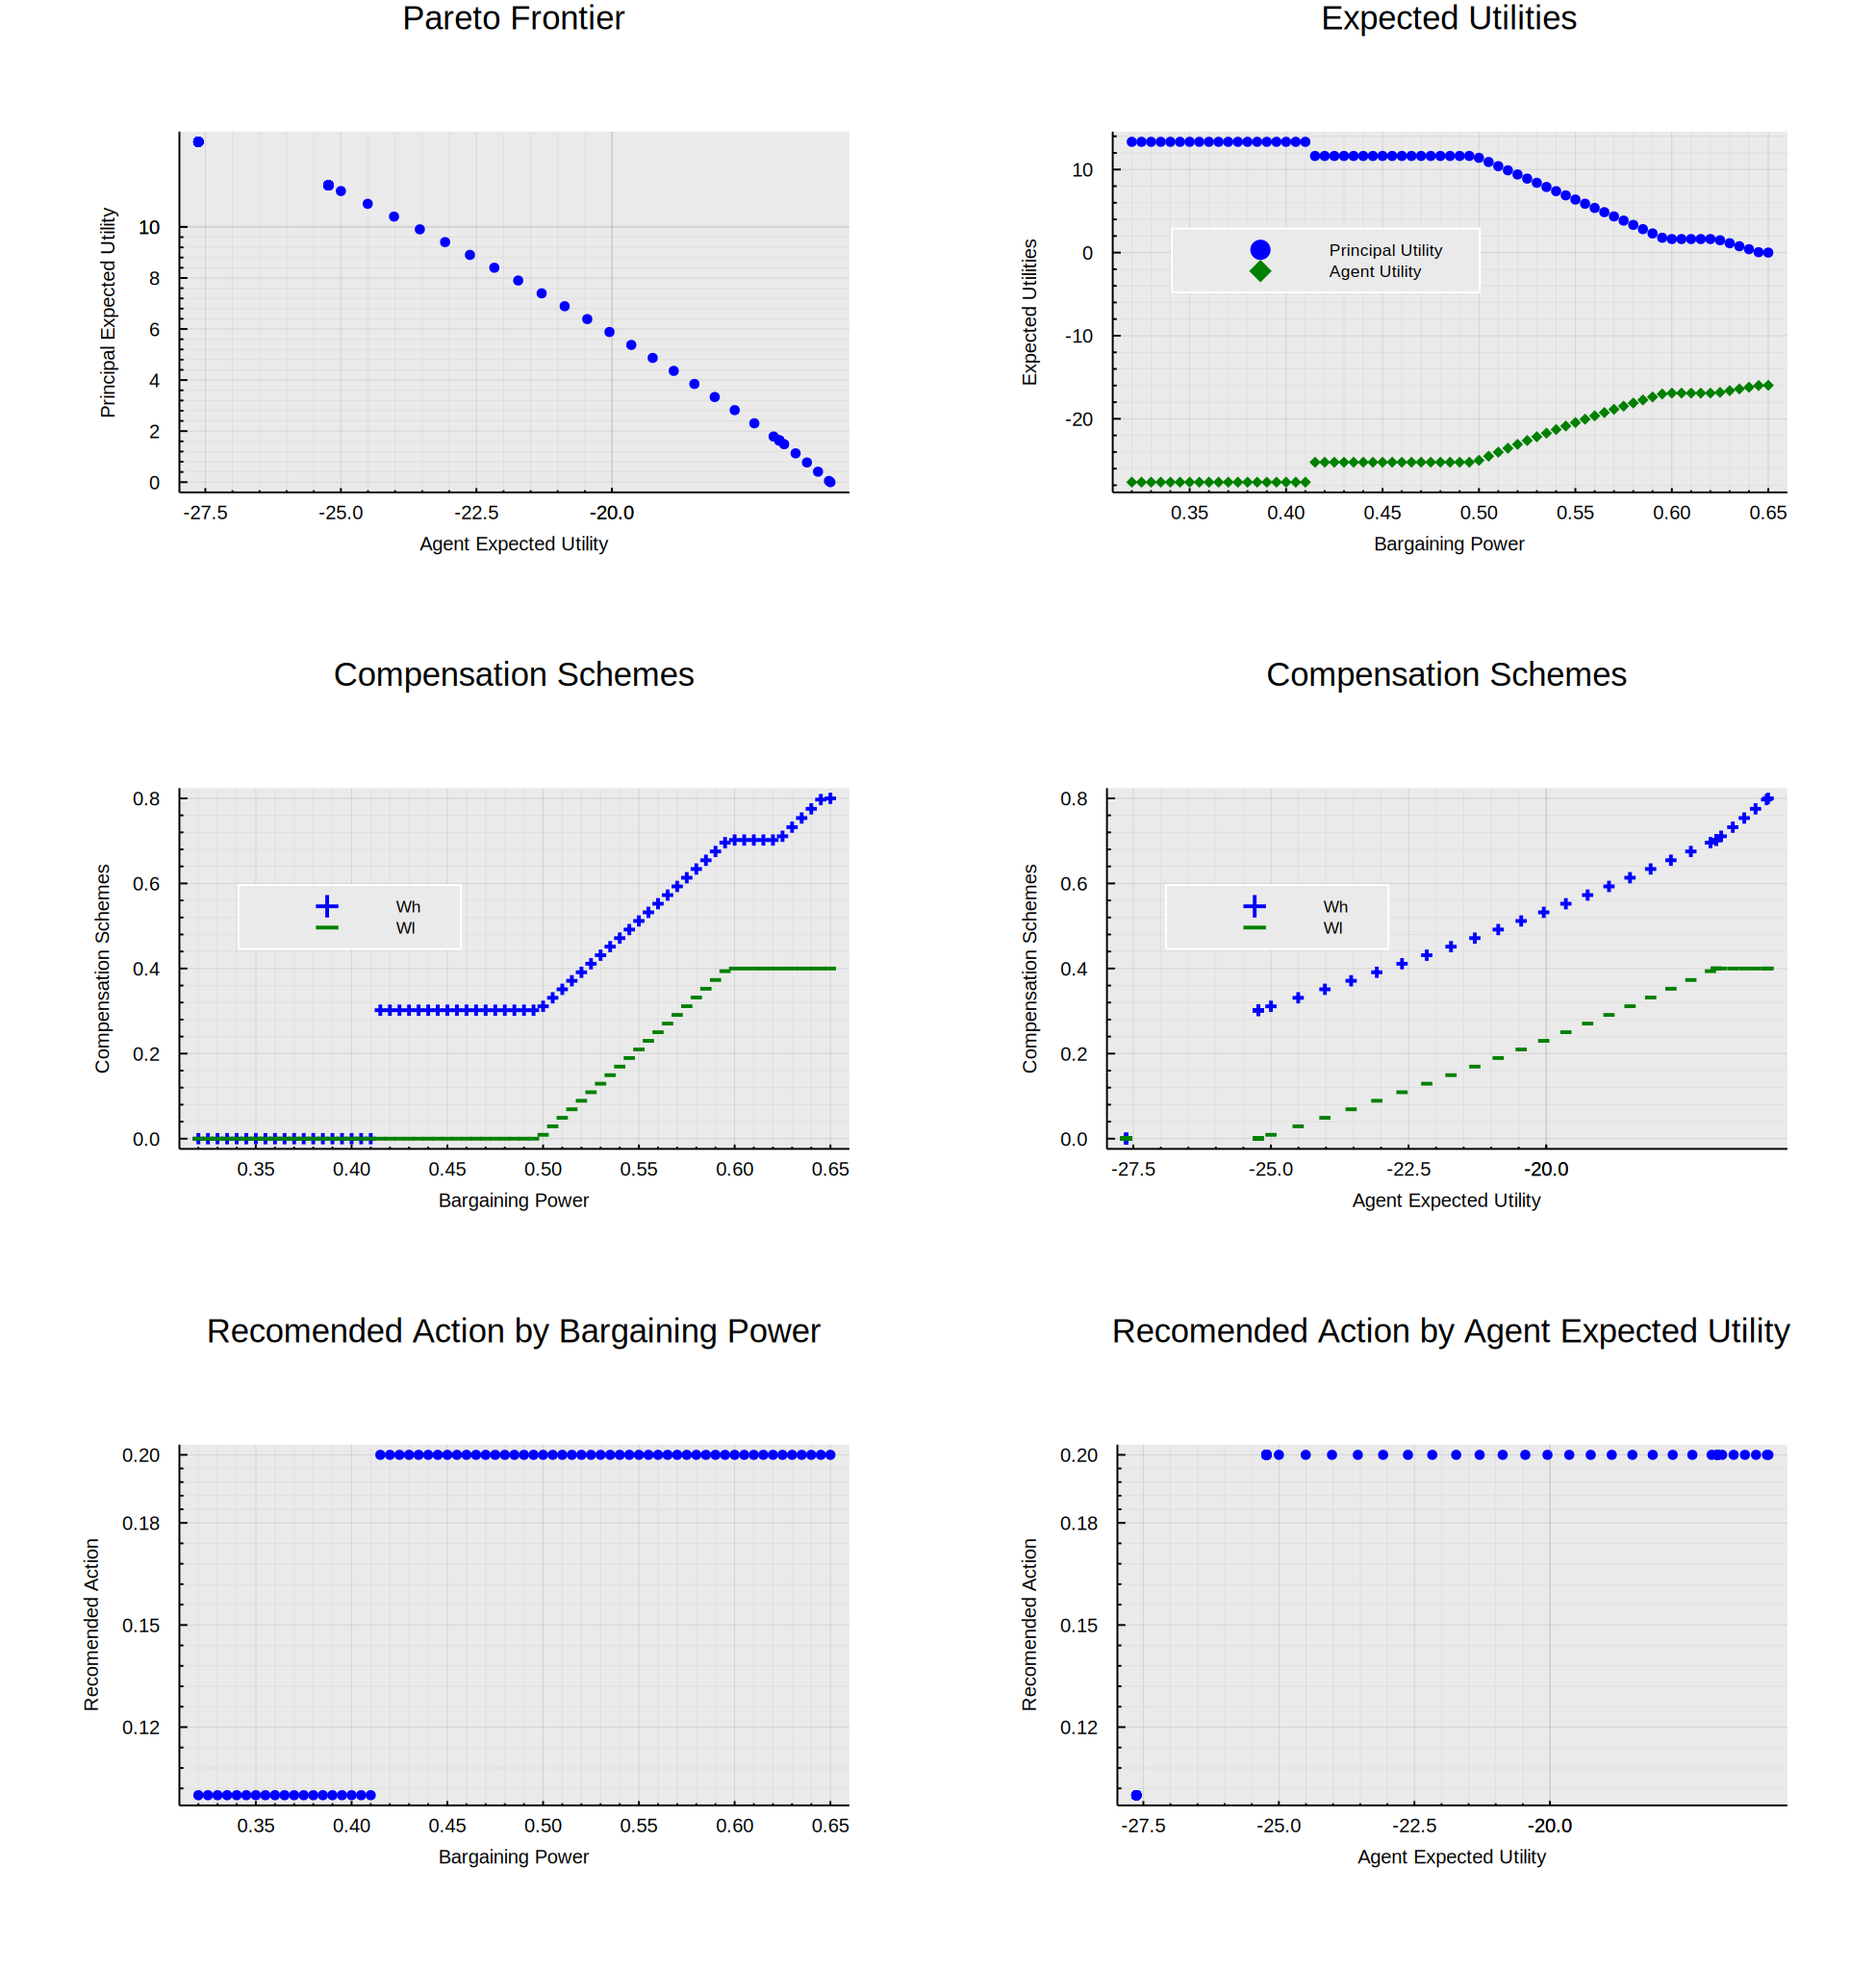

In [28]:
using Plots, Plots.PlotMeasures    # Plots packages load
theme(:ggplot2)     # Graphics theme

#Recomended Action by bargaining power plot.
pl1=scatter(Data_Weighted_Sum[:,"Delta"], Data_Weighted_Sum[:,"Recomended_Action"], 
    color = [:blue],
    legend = false,
    title = "Recomended Action by Bargaining Power", 
    xlabel = "Bargaining Power",
    ylabel =  "Recomended Action")

#Pareto Frontier Plot 
pl2=scatter(Data_Weighted_Sum[:,"Agent_Utility"], Data_Weighted_Sum[:,"Principal_Utility"],
    color = [:blue],
    legend = false,
    title = "Pareto Frontier", 
    xlabel = "Agent Expected Utility",
    ylabel =  "Principal Expected Utility") 

#Compensation Schemes by bargaining power plot. 
pl3=scatter([Data_Weighted_Sum[:,"Delta"], Data_Weighted_Sum[:,"Delta"]], [Data_Weighted_Sum[:,"High_Compensation"], Data_Weighted_Sum[:,"Low_Compensation"]],
    color = [:blue :green],
    shape = [:+ :hline :utri],
    labels = ["Wh" "Wl"],
    legend = :topleft,
    title = "Compensation Schemes", 
    xlabel = "Bargaining Power",
    ylabel =  "Compensation Schemes")

#Compensation Schemes by agent utility plot
pl4=scatter([Data_Weighted_Sum[:, "Agent_Utility"], Data_Weighted_Sum[:, "Agent_Utility"]], [Data_Weighted_Sum[:, "High_Compensation"], Data_Weighted_Sum[:, "Low_Compensation"]],
    color = [:blue :green],
    shape = [:+ :hline :utri],
    labels = ["Wh" "Wl"],
    legend = :topleft,
    title = "Compensation Schemes", 
    xlabel = "Agent Expected Utility",
    ylabel =  "Compensation Schemes")

#Expected Agent and Principal utilities plot. 
pl5=scatter([Data_Weighted_Sum[:,"Delta"], Data_Weighted_Sum[:,"Delta"]], [Data_Weighted_Sum[:, "Principal_Utility"], Data_Weighted_Sum[:, "Agent_Utility"]],
    color = [:blue :green],
    shape = [:circle :diamond :utri],
    labels = ["Principal Utility" "Agent Utility"],
    legend = :topleft,
    title = "Expected Utilities", 
    xlabel = "Bargaining Power",
    ylabel =  "Expected Utilities") 

#Recomended Action by agent expected utility plot.
pl6=scatter(Data_Weighted_Sum[:, "Agent_Utility"], Data_Weighted_Sum[:, "Recomended_Action"],
    color = [:blue],
    legend = false,
    title = "Recomended Action by Agent Expected Utility", 
    xlabel = "Agent Expected Utility",
    ylabel =  "Recomended Action")

#layout
l = @layout [a b ; c d; e f]

#figure
complete_plot = plot(pl2, pl5, pl3, pl4, pl1, pl6, layout = l,
    size = (1000,1050),
    dpi = 1000,
    xtickfont = font(7), 
    ytickfont = font(7), 
    guidefont = font(7), 
    titlefont = font(12),
    legendfont = font(6),
    markersize = 3,
    margin = 10mm) 
display(complete_plot)
#Save figure
savefig("Wangs Utility Function/Info_Wang")